In [1]:
# Imports
import pandas as pd # for Data

# For viaualisation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for time stamps
from datetime import datetime as dt

In [11]:
# import data from yfinance
import yfinance as yf

# list of the companies
company_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# set the time frame
end_date = dt.today()
start_date = dt(end_date.year-10, end_date.month , end_date.day)

# get the data
data = yf.download(company_list, start=start_date, end=end_date,progress=False)


In [13]:
# took only apple data
apple_data = data.xs('AAPL', level='Ticker', axis=1)

# convert this raw data to a dataframe
df = pd.DataFrame(apple_data)
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2014-10-06 00:00:00+00:00,22.113337,24.905001,25.162500,24.855000,24.987499,148204800
2014-10-07 00:00:00+00:00,21.920204,24.687500,25.030001,24.682501,24.857500,168376800
2014-10-08 00:00:00+00:00,22.375259,25.200001,25.277500,24.577499,24.690001,229618800
2014-10-09 00:00:00+00:00,22.424097,25.254999,25.594999,25.152500,25.385000,309506000
2014-10-10 00:00:00+00:00,22.359726,25.182501,25.507500,25.075001,25.172501,265326400


In [17]:
df.shape

(2517, 6)

In [21]:
df.describe()

Price,Adj Close,Close,High,Low,Open,Volume
count,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03
mean,89.302564,91.354944,92.262115,90.360367,91.283619,1.209391e+08
std,62.756009,62.269025,62.879571,61.591942,62.218577,6.949564e+07
min,20.720036,22.584999,22.917500,22.367500,22.500000,2.404830e+07
25%,33.118690,35.547501,35.730000,35.277500,35.527500,7.415070e+07
50%,54.617817,56.907501,57.417500,56.587502,56.990002,1.034332e+08
75%,147.004745,149.029999,150.369995,147.479996,148.899994,1.477132e+08
max,234.548523,234.820007,237.229996,233.089996,236.479996,6.488252e+08


LSTM to predict closing price

Steps:
1. Collecting the data
2. Preprocess the data- train and test
3. Create a stacked LSTM Model
4. Predict the test data and plot the output
5. Predict the future 30 days and plot the output

In [49]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
data.head()

,Close
Date,
2014-10-06 00:00:00+00:00,24.905001
2014-10-07 00:00:00+00:00,24.687500
2014-10-08 00:00:00+00:00,25.200001
2014-10-09 00:00:00+00:00,25.254999
2014-10-10 00:00:00+00:00,25.182501


In [59]:
#LSTM are sensitive to scale
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(data).reshape(-1,1))

In [63]:
df1.shape

(2517, 1)

In [68]:
training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train,test=df1[0:training_size,:],df1[training_size:len(df1),:1]

Creating dataset considering the current close value depends on the last "timestep" number of close values

In [75]:
def create_dataset(dataset,timestep=1):
    datax,datay=[],[]
    for i in range(len(dataset)-timestep-1):
        a=dataset[i:(i+timestep),0]
        datax.append(a)
        datay.append(dataset[i+timestep,0])
    return np.array(datax),np.array(datay)

In [81]:
timestep=100
x_train,y_train=create_dataset(train,timestep)
x_test,y_test=create_dataset(test,timestep)

In [83]:
x_train

array([[0.01093129, 0.00990648, 0.01232126, ..., 0.04529177, 0.04721182,
        0.04490307],
       [0.00990648, 0.01232126, 0.01258039, ..., 0.04721182, 0.04490307,
        0.04564516],
       [0.01232126, 0.01258039, 0.0122388 , ..., 0.04490307, 0.04564516,
        0.0459632 ],
       ...,
       [0.63224727, 0.63465024, 0.61005486, ..., 0.60237467, 0.60397672,
        0.60864132],
       [0.63465024, 0.61005486, 0.62159865, ..., 0.60397672, 0.60864132,
        0.59959475],
       [0.61005486, 0.62159865, 0.5838575 , ..., 0.60864132, 0.59959475,
        0.56491621]])

In [85]:
x_train.shape

(1912, 100)

In [89]:
#reshape input to be [samples.timesteps.features] as required by the LSTM
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [93]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [95]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - loss: 0.0397 - val_loss: 0.0093
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 6.0798e-04 - val_loss: 0.0036
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 5.1311e-04 - val_loss: 0.0027
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 4.6960e-04 - val_loss: 0.0027
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 5.1375e-04 - val_loss: 0.0032
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 4.4786e-04 - val_loss: 0.0024
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 4.7394e-04 - val_loss: 0.0036
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 4.6345e-04 - val_loss: 0.0040
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 4.3487e-04 - val_loss: 0.0023
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 4.5389e-04 - val_loss: 0.0024
Epoch 12/100

In [102]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [103]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [104]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

86.598226304722

In [106]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

187.20198500593747

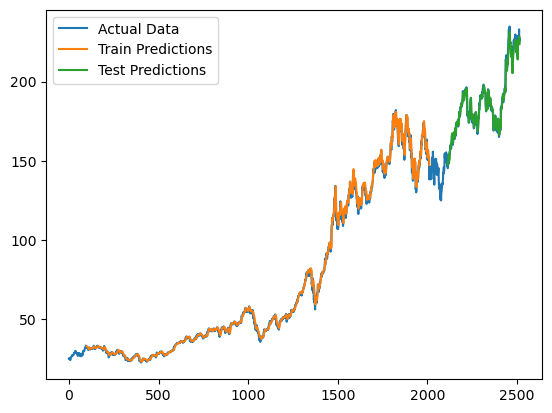

In [114]:
import numpy as np
import matplotlib.pyplot as plt

# Assume df1, train_predict, and test_predict are already defined
# shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1), label="Actual Data")  # Baseline
plt.plot(trainPredictPlot, label="Train Predictions")         # Train Predictions
plt.plot(testPredictPlot, label="Test Predictions")           # Test Predictions

# Adding legends to the plot
plt.legend()

# Show plot
plt.show()
